<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/Karen_Rosero/Aula_4_Exerc%C3%ADcio_KarenRosero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

Peguei dicas da implementação de algumas funções dos notebooks de Larissa Santesso e Gabriel Lopes. Agradeço pelo aporte. 

## Importação das bibliotecas

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST
from math import ceil

## Fixando as seeds

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [ ]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [ ]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [ ]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [ ]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

class KDataLoader():
    def __init__(self, dataset_train=dataset_train, batch_size=batch_size, shuffle=True):
      self.batch_size = batch_size
      self.idx = 0
      if shuffle:
          self.dataset_train = list(dataset_train)
          random.shuffle(self.dataset_train)
      else:
          self.dataset_train = list(dataset_train)
      
      self.n_batch = int(ceil(len(self.dataset_train)/self.batch_size))
        
    def __len__(self):
      return self.n_batch

    def __iter__(self):
      self.idx = 0
      return self

    def __next__(self):
      if self.batch_size + self.idx > len(self.dataset_train):
          self.batch_size = len(self.dataset_train) - self.idx
          if self.idx >= len(self.dataset_train):
              raise StopIteration
      for idx_b in range(self.batch_size):
          x, y = self.dataset_train[idx_b + self.idx]
          y = torch.tensor([y])
          if idx_b == 0:   #primeiro batch não concateno 
              b_x = x
              b_y = y
          else:
              b_x = torch.cat((b_x, x))
              b_y = torch.cat((b_y, y))
      self.idx += batch_size
      return b_x, b_y

loader_train = KDataLoader(dataset_train, batch_size=batch_size, shuffle=False)      

In [ ]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [ ]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class Model():
    def __init__(self, input_vector: int, output_vector: int):
        self.weights = torch.zeros(output_vector, input_vector, requires_grad=True)
        self.bias = torch.zeros(output_vector, requires_grad=True)

    def __call__(self,in_v):    
        y_pred = torch.matmul(in_v,torch.t(self.weights))+self.bias.unsqueeze(0)
        return y_pred
    
    def parameters(self):
        return self.weights, self.bias

model = Model(28*28,10)

## Treinamento

### Inicialização dos parâmetros

In [ ]:
n_epochs = 50
lr = 0.1

## Definição da Loss



CrossEntropyLoss = $\dfrac{-\sum(-z_{y}+\log(\sum_{j}exp(z_{j})))}{N}$

In [ ]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()
# baseado na solução do Notebook de Larissa Santesso

class CrossEntropyLoss:
    def __init__(self):
        self.loss = 0

    def __call__(self, predict, targets):  
        log_sum_1 = torch.log(torch.sum(torch.exp(predict), dim=1, keepdim=True))
        pred = predict.gather(dim=1, index= targets.unsqueeze(dim=1)).squeeze(dim=1)
        num = -pred + log_sum_1
        loss_total = torch.mean(num)
        return loss_total

criterion = CrossEntropyLoss()

# Definição do Optimizer

In [ ]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD_Opt():
    def __init__(self, parameters:tuple, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        for prm in self.parameters:
            prm.data = prm.data - self.learning_rate*prm.grad

    def zero_grad(self):
        for prm in self.parameters:
            prm.grad = torch.zeros_like(prm.data)    

optimizer = SGD_Opt(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [ ]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    #print("epoca")
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    loader_train = KDataLoader(dataset_train, batch_size=50, shuffle=False)      
    for x_train, y_train in loader_train:
        #print('x_train', x_train.shape, y_train.shape)
        #print('y_train', y_train.shape)
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        #print("input",inputs.shape)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)
        #print("loss", loss.shape, loss)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.197968602180481
Epoch: 1/49 Loss: 0.8676231503486633
Epoch: 2/49 Loss: 0.7226787805557251
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809751152992249
Epoch: 5/49 Loss: 0.5387412309646606
Epoch: 6/49 Loss: 0.5056464076042175
Epoch: 7/49 Loss: 0.47862714529037476
Epoch: 8/49 Loss: 0.45589369535446167
Epoch: 9/49 Loss: 0.4363219738006592
Epoch: 10/49 Loss: 0.4191649854183197
Epoch: 11/49 Loss: 0.40390461683273315
Epoch: 12/49 Loss: 0.39016813039779663
Epoch: 13/49 Loss: 0.37768006324768066
Epoch: 14/49 Loss: 0.3662315309047699
Epoch: 15/49 Loss: 0.3556614816188812
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667421340942383
Epoch: 18/49 Loss: 0.3280736207962036
Epoch: 19/49 Loss: 0.3199736475944519
Epoch: 20/49 Loss: 0.31231844425201416
Epoch: 21/49 Loss: 0.3050612211227417
Epoch: 22/49 Loss: 0.2981624901294708
Epoch: 23/49 Loss: 0.2915886342525482
Epoch: 24/49 Loss: 0.28531041741371155
Epoch: 25/49 Loss: 0.27930301427841187
Epoch: 26/49 

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

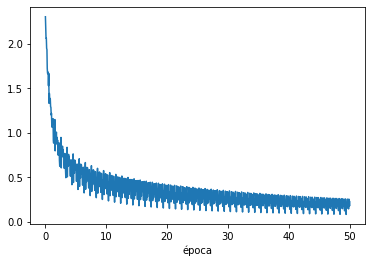

In [ ]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

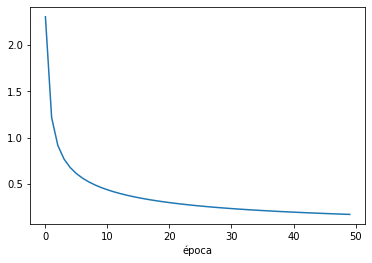

In [ ]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [ ]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [ ]:
dataset_dir = '../data/'

dataset_test_full = MNIST(dataset_dir, train=False, download=True,
                           transform=torchvision.transforms.ToTensor())

In [ ]:
indices_2 = torch.randperm(len(dataset_test_full))[:1000]
dataset_2 = torch.utils.data.Subset(dataset_test_full, indices_2)

In [ ]:
loader2 = KDataLoader(dataset_2, batch_size=1000, shuffle=False) 
x_test, y_test = next(iter(loader2))
x_test.shape, y_test.shape

In [ ]:
predicted = model(x_test.view(-1, 28 * 28))
print(predicted.shape)
print('Exemplo de saída predita:',predicted[0].detach().numpy())

torch.Size([1000, 10])
Exemplo de saída predita: [-2.0532587 -1.0199149 -3.6389837  1.5762388 -0.1769077  1.2000287
 -2.9737525  1.7013202  2.2785833  3.1063194]


In [ ]:
# Computo camada softmax das saídas preditas
sum1 = torch.sum(torch.exp(predicted), dim=1, keepdim=True)
prob = (torch.exp(predicted)/sum1)
print(prob.shape)
print('Exemplo de probabilidades de uma amostra:',prob[0].detach().numpy())

torch.Size([1000, 10])
Exemplo de probabilidades de uma amostra: [0.0027218  0.00764948 0.00055742 0.1025952  0.01777236 0.0704273
 0.00108415 0.11626505 0.2070863  0.47384098]


In [ ]:
# Extraindo a classe correspondente à maior probabilidade de cada amostra
classe_pred = torch.argmax(prob, axis = 1)
# Amostras que foram classificadas corretamente 
correto = np.where(classe_pred.numpy()==y_test.numpy())
# Das amostras classificadas corretamente, qual é a maior probabilidade correspondente
probs_corretas = prob[correto, classe_pred[correto]]
s_prob_max1 = torch.argmax(probs_corretas) 
prob_max1 = torch.max(probs_corretas)
print('Amostra classificada corretamente com maior probabilidade:', s_prob_max1.numpy(), ' Probabilidade:', prob_max1.detach().numpy())
errado = np.where(classe_pred.numpy()!=y_test.numpy())
probs_erradas = prob[errado, classe_pred[errado]]
s_prob_max2 = torch.argmax(probs_erradas) 
prob_max2 = torch.max(probs_erradas)
print('Amostra classificada erradamente com maior probabilidade:', s_prob_max2.numpy(), ' Probabilidade:', prob_max2.detach().numpy())
s_prob_min1 = torch.argmin(probs_corretas) 
prob_min1 = torch.min(probs_corretas)
print('Amostra classificada corretamente com menor probabilidade:', s_prob_min1.numpy(), ' Probabilidade:', prob_min1.detach().numpy())
s_prob_min2 = torch.argmin(probs_erradas) 
prob_min2 = torch.min(probs_erradas)
print('Amostra classificada erradamente com menor probabilidade:', s_prob_min2.numpy(), ' Probabilidade:', prob_min2.detach().numpy())

Amostra classificada corretamente com maior probabilidade: 151  Probabilidade: 0.99995136
Amostra classificada erradamente com maior probabilidade: 3  Probabilidade: 0.9970908
Amostra classificada corretamente com menor probabilidade: 326  Probabilidade: 0.23923074
Amostra classificada erradamente com menor probabilidade: 66  Probabilidade: 0.25418633


## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
